# Product Sentiment Classifier

## Data Cleaning and EDA
Import necessary libraries

In [1]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.collocations import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#from xgboost import XGBClassifier
from sklearn.metrics import (plot_confusion_matrix)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from collections import Counter
%matplotlib inline

%run -i "functions/clean_lemmatize_token.py"
%run -i "functions/clean_lemmatize_token_alt.py"
%run -i "functions/predict_sentiment.py"
%run -i "functions/report.py"

Import data from data.world.

In [2]:
df = pd.read_csv('https://query.data.world/s/zbehvjkmiewbkln44rae6iphum4v3g', 
                 encoding = "ISO-8859-1")
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Rename columns

In [3]:
df=df.rename(columns = {'emotion_in_tweet_is_directed_at':
                        'brand_product',
                        'is_there_an_emotion_directed_at_a_brand_or_product':
                        'sentiment'})
df.head()

,tweet_text,brand_product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Explored data set with info() method. 1 NaN value present in tweet_text column and ~6,000 in brand_product column. Will need to address prior to modeling

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text       9092 non-null object
brand_product    3291 non-null object
sentiment        9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


Remove NaN tweet_text from DataFrame

In [5]:
df[df['tweet_text'].isna()]

,tweet_text,brand_product,sentiment
6,NaN,NaN,No emotion toward brand or product


In [6]:
df.drop(inplace= True, index=6)

### Exploration
Explored Sentiment category. Most tweets are marked as having No emotion which will not help initial binary classification model. Most data in data set will only be usuable when model is built to take into account neutral sentiment

In [7]:
df.groupby('sentiment').count()

,tweet_text,brand_product
sentiment,,
I can't tell,156,9
Negative emotion,570,519
No emotion toward brand or product,5388,91
Positive emotion,2978,2672


In [8]:
df.loc[df['sentiment'] == "I can't tell"]

,tweet_text,brand_product,sentiment
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell
237,Just what America needs. RT @mention Google to...,NaN,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell
...,...,...,...
9020,It's funny watching a room full of people hold...,NaN,I can't tell
9032,"@mention yeah, we have @mention , Google has n...",NaN,I can't tell
9037,"@mention Yes, the Google presentation was not ...",NaN,I can't tell
9058,&quot;Do you know what Apple is really good at...,NaN,I can't tell


In [9]:
df['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

Dummied Sentiment Column to help with visulizations to compare sentiment across brands

In [10]:
df1=pd.get_dummies(df['sentiment'])
df1.head()

,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion
0,0,1,0,0
1,0,0,0,1
2,0,0,0,1
3,0,1,0,0
4,0,0,0,1


In [11]:
df_dummied=df.join(df1).drop(columns='sentiment')
df_dummied.head()

,tweet_text,brand_product,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,1,0,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,0,0,0,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,0,0,0,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,1,0,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,0,0,0,1


Made visualization to explore distribution of sentiment across brand/product. Will combine Apple and Google products to further explore distribution. Sentiment is overwhelmingly positive across all products and most sentiment data is logged for Apple products

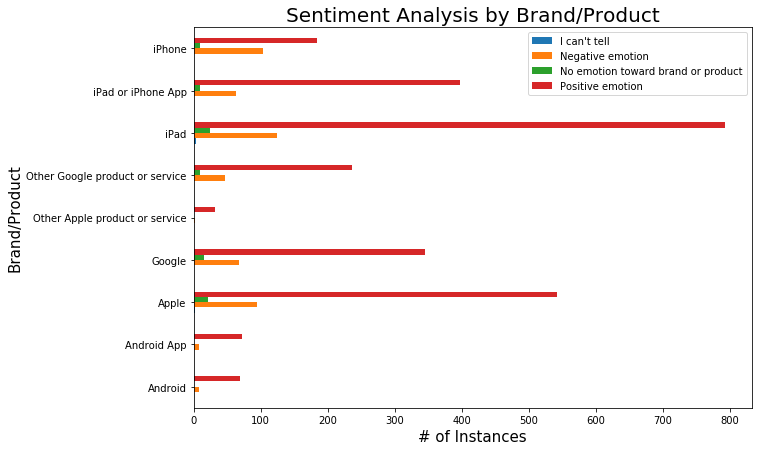

In [12]:
df_dummied.groupby('brand_product').sum().plot(kind='barh', 
                                               figsize=(10,7))
plt.title('Sentiment Analysis by Brand/Product', size=20)
plt.ylabel('Brand/Product', size=15)
plt.xlabel('# of Instances', size=15)
plt.show()

Made below visualization to explore the missing brand_product classifications for each sentiment

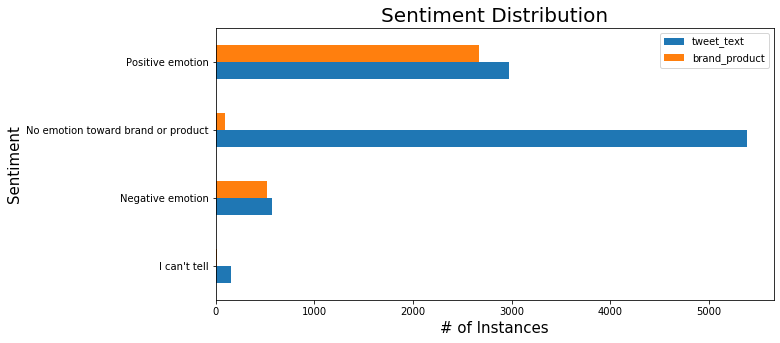

In [13]:
df.groupby('sentiment').count().plot(kind='barh',
                                     figsize=(10,5))
plt.title('Sentiment Distribution', size=20)
plt.ylabel('Sentiment', size=15)
plt.xlabel('# of Instances',size=15)
plt.show()

Usable data (Positive or Negative sentiment) for baseline first model is 39.02%. Will be necessary to eventually build a multiclass classifier with No Emotion classification

In [14]:
usable_data=round(len(df.loc[(df['sentiment'] == 'Positive emotion') | 
                             (df['sentiment'] == 'Negative emotion')])/len(df) * 100,2)
print('Percentage of Data with either Positive or Negative Sentiment: {}%'.format(usable_data))

Percentage of Data with either Positive or Negative Sentiment: 39.02%


Combined Apple and Google product names together to explore further visualizations

In [15]:
df_dummied['brand_product']=df_dummied['brand_product'].replace(to_replace = ['iPad','Apple',
                                                                                    'iPad or iPhone App','iPhone',
                                                                                    'Other Apple product or service'],value='apple_product')
df_dummied['brand_product'] = df_dummied['brand_product'].replace(['Google',
                                                                        'Other Google product or service',
                                                                        'Android App', 'Android'],'android_product')
df_dummied['brand_product'].value_counts()

apple_product      2409
android_product     882
Name: brand_product, dtype: int64

Combined Brand_product columns to show difference in amount of information for each product

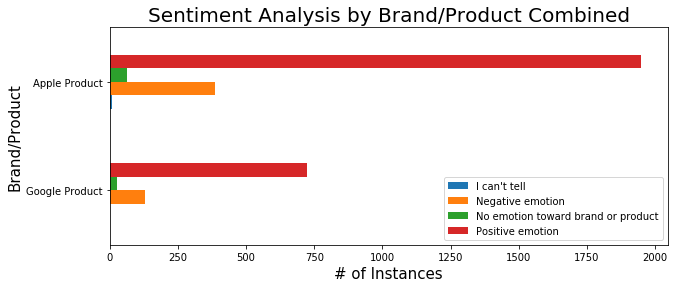

In [16]:
df_dummied.groupby('brand_product').sum().plot(kind='barh', figsize=(10,4))
plt.title('Sentiment Analysis by Brand/Product Combined', size=20)
plt.ylabel('Brand/Product', size=15)
plt.xlabel('# of Instances', size=15)
plt.yticks(np.arange(2),['Google Product','Apple Product'])
plt.show()

Made a copy of the data frame to further explore EDA options

In [17]:
df_eda = df
df_eda.head()

,tweet_text,brand_product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Used an alternative version of our clean_lemmatize_token function to preprocess data for additional EDA

In [18]:
def clean_lemmatize_token_alt(tweet):
    stop_words = set(stopwords.words('english'))
    cleaned = tweet.translate(str.maketrans('', '', string.punctuation)).lower()
    tokenized = word_tokenize(cleaned)
    filtered = [w for w in tokenized if not w in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    for word in filtered:
        lemmatized.append(lemmatizer.lemmatize(word))
    to_remove = ['rt','mention','sxsw','link']
    lemmatized = [w for w in lemmatized if w not in to_remove]
    #lemmatized = ' '.join(lemmatized)
    return lemmatized

In [19]:
df_eda['tweet_text'] = df_eda['tweet_text'].map(lambda x: clean_lemmatize_token_alt(x))
df_eda.head()

,tweet_text,brand_product,sentiment
0,"[wesley83, 3g, iphone, 3, hr, tweeting, riseau...",iPhone,Negative emotion
1,"[jessedee, know, fludapp, awesome, ipadiphone,...",iPad or iPhone App,Positive emotion
2,"[swonderlin, wait, ipad, 2, also, sale]",iPad,Positive emotion
3,"[hope, year, festival, isnt, crashy, year, iph...",iPad or iPhone App,Negative emotion
4,"[sxtxstate, great, stuff, fri, marissa, mayer,...",Google,Positive emotion


In [20]:
df_eda['brand_product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: brand_product, dtype: int64

Split data set out into different divisions to visualize bigrams of Apple and Android Mobile product tweets

In [21]:
df_pos_apple_mobile = df_eda.loc[(df_eda['sentiment'] == 'Positive emotion') & (df_eda['brand_product'] == 'iPad') 
                                 | (df_eda['brand_product'] == 'iPhone') | (df_eda['brand_product'] == 'iPad or iPhone App')]
df_neg_apple_mobile = df_eda.loc[(df_eda['sentiment'] == 'Negative emotion') & (df_eda['brand_product'] == 'iPad') 
                                 | (df_eda['brand_product'] == 'iPhone') | (df_eda['brand_product'] == 'iPad or iPhone App')]
df_pos_android_mobile = df_eda.loc[(df_eda['sentiment'] == 'Positive emotion') & (df_eda['brand_product'] == 'Other Google Product or Service') 
                                 | (df_eda['brand_product'] == 'Android App') | (df_eda['brand_product'] == 'Android')]
df_neg_android_mobile = df_eda.loc[(df_eda['sentiment'] == 'Negative emotion') & (df_eda['brand_product'] == 'Other Google Product or Service') 
                                 | (df_eda['brand_product'] == 'Android App') | (df_eda['brand_product'] == 'Android')]

In [22]:
pos_apple_mobile_tweet_list = df_pos_apple_mobile['tweet_text']
neg_apple_mobile_tweet_list = df_neg_apple_mobile['tweet_text']
pos_android_mobile_list = df_pos_android_mobile['tweet_text']
neg_android_mobile_list = df_neg_android_mobile['tweet_text']

In [23]:
pos_apple_mobile_concat = []
neg_apple_mobile_concat = []
pos_android_mobile_concat = []
neg_android_mobile_concat = []

for tweet in pos_apple_mobile_tweet_list:
    pos_apple_mobile_concat += tweet
for tweet in neg_apple_mobile_tweet_list:
    neg_apple_mobile_concat += tweet
for tweet in pos_android_mobile_list:
    pos_android_mobile_concat += tweet  
for tweet in neg_android_mobile_list:
    neg_android_mobile_concat += tweet

In [24]:
len(pos_apple_mobile_concat)

15438

In [25]:
mobile_concat_list = [pos_apple_mobile_concat, neg_apple_mobile_concat, pos_android_mobile_concat,
                      neg_android_mobile_concat]

## Bigrams by Raw Frequency

In [26]:
mobile_tweets_scored_list = []
for mobile_list in mobile_concat_list:
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    tweet_finder = BigramCollocationFinder.from_words(mobile_list)
    tweets_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)
    mobile_tweets_scored_list.append(tweets_scored)

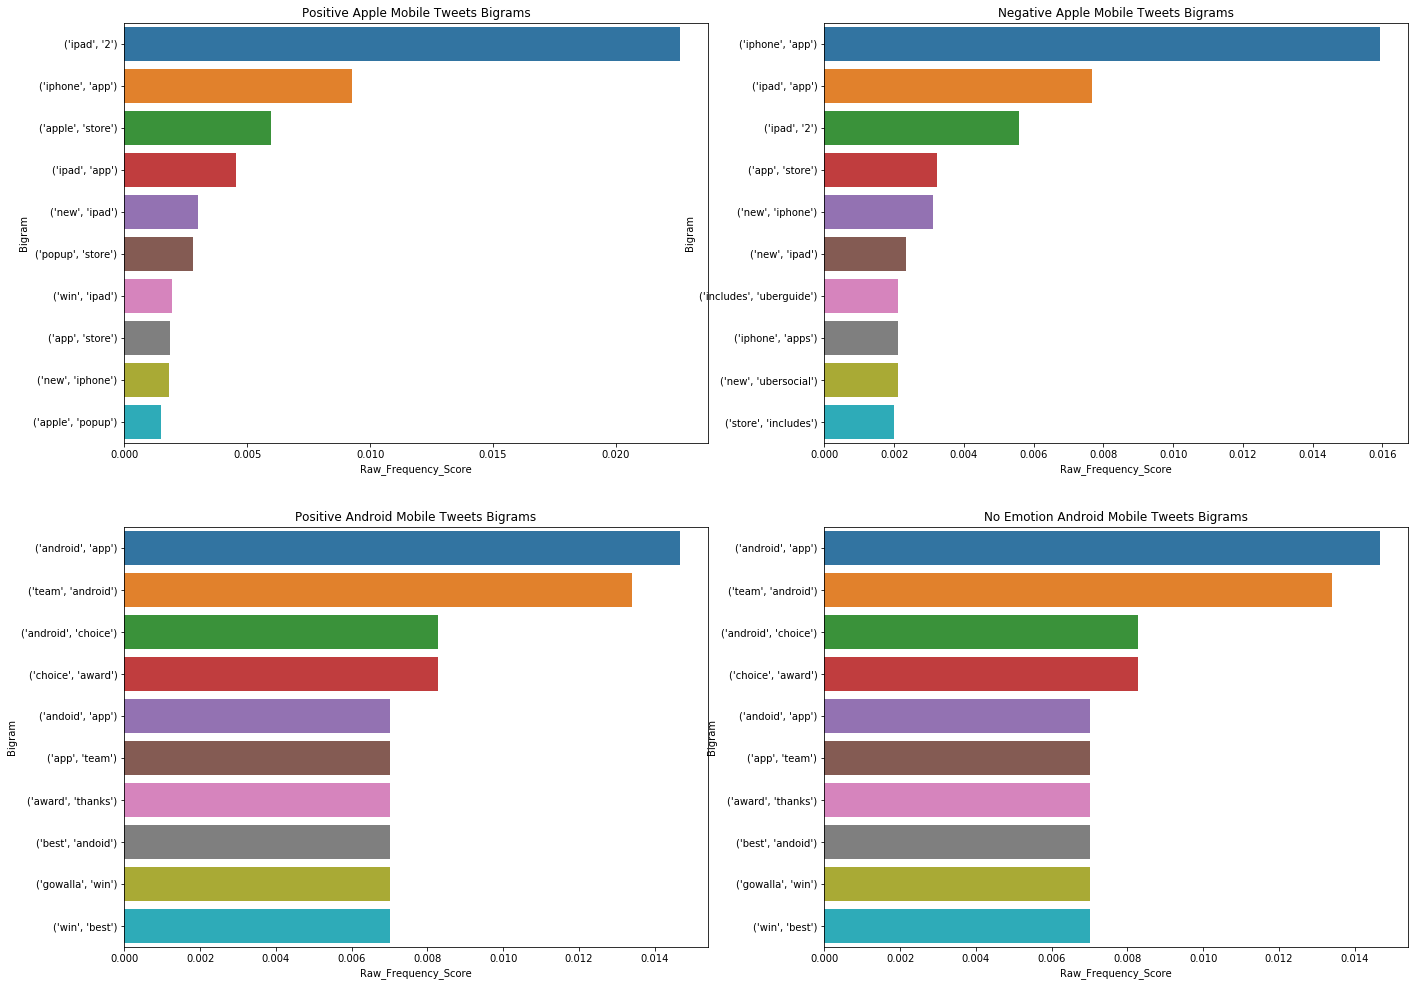

In [27]:
df_mobile_graph1 = pd.DataFrame(mobile_tweets_scored_list[0][:10], columns = ['Bigram','Raw_Frequency_Score'])
df_mobile_graph2 = pd.DataFrame(mobile_tweets_scored_list[1][:10], columns = ['Bigram','Raw_Frequency_Score'])
df_mobile_graph3 = pd.DataFrame(mobile_tweets_scored_list[2][:10], columns = ['Bigram','Raw_Frequency_Score'])
df_mobile_graph4 = pd.DataFrame(mobile_tweets_scored_list[3][:10], columns = ['Bigram','Raw_Frequency_Score'])
fig, axs = plt.subplots(2,2)
fig.set_figheight(17)
fig.set_figwidth(23)
axs[0,0].title.set_text('Positive Apple Mobile Tweets Bigrams')
axs[0,1].title.set_text('Negative Apple Mobile Tweets Bigrams')
axs[1,0].title.set_text('Positive Android Mobile Tweets Bigrams')
axs[1,1].title.set_text('No Emotion Android Mobile Tweets Bigrams')
sns.barplot(data=df_mobile_graph1, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[0,0])
sns.barplot(data=df_mobile_graph2, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[0,1])
sns.barplot(data=df_mobile_graph3, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[1,0])
sns.barplot(data=df_mobile_graph4, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[1,1])
plt.show()

Combined all Apple products and all Google products together

In [28]:
df_eda['brand_product']=df_eda['brand_product'].replace(to_replace = ['iPad','Apple',
                                                                                    'iPad or iPhone App','iPhone',
                                                                                    'Other Apple product or service'],value='apple_product')
df_eda['brand_product'] = df_eda['brand_product'].replace(['Google',
                                                                        'Other Google product or service',
                                                                        'Android App', 'Android'],'android_product')
df_eda['brand_product'].value_counts(
)

apple_product      2409
android_product     882
Name: brand_product, dtype: int64

Created new data frames based on different brands and sentiments to plot bigrams of most common word pairs

In [29]:
df_pos = df_eda.loc[df_eda['sentiment'] == 'Positive emotion']
df_neg = df_eda.loc[df_eda['sentiment'] == 'Negative emotion']
df_none = df_eda.loc[df_eda['sentiment'] == 'No emotion toward brand or product']
df_apple = df_eda.loc[df_eda['brand_product'] == 'apple_product']
df_google = df_eda.loc[df_eda['brand_product'] == 'android_product']
df_pos_apple = df_eda.loc[(df_eda['brand_product'] == 'apple_product') & (df_eda['sentiment'] == 'Positive emotion')]
df_neg_apple = df_eda.loc[(df_eda['brand_product'] == 'apple_product') & (df_eda['sentiment'] == 'Negative emotion')]
df_none_apple = df_eda.loc[(df_eda['brand_product'] == 'apple_product') & (df_eda['sentiment'] == 'No emotion toward brand or product')]
df_pos_google = df_eda.loc[(df_eda['brand_product'] == 'android_product') & (df_eda['sentiment'] == 'Positive emotion')]
df_neg_google = df_eda.loc[(df_eda['brand_product'] == 'android_product') & (df_eda['sentiment'] == 'Negative emotion')]
df_none_google = df_eda.loc[(df_eda['brand_product'] == 'android_product') & (df_eda['sentiment'] == 'No emotion toward brand or product')]

In [30]:
tweet_list = df_eda['tweet_text']
pos_tweet_list = df_pos['tweet_text']
neg_tweet_list = df_neg['tweet_text']
none_tweet_list = df_none['tweet_text']
apple_tweet_list = df_apple['tweet_text']
apple_pos_tweet_list = df_pos_apple['tweet_text']
apple_neg_tweet_list = df_neg_apple['tweet_text']
apple_none_tweet_list = df_none_apple['tweet_text']
google_tweet_list = df_google['tweet_text']
google_pos_tweet_list = df_pos_google['tweet_text']
google_neg_tweet_list = df_neg_google['tweet_text']
google_none_tweet_list = df_none_google['tweet_text']

In [31]:
tweet_concat = []
pos_tweet_concat = []
neg_tweet_concat = []
none_tweet_concat = []
apple_tweet_concat = []
apple_pos_tweet_concat = []
apple_neg_tweet_concat = []
apple_none_tweet_concat = []
google_tweet_concat = []
google_pos_tweet_concat = []
google_neg_tweet_concat = []
google_none_tweet_concat = []

for tweet in tweet_list:
    tweet_concat += tweet
for tweet in pos_tweet_list:
    pos_tweet_concat += tweet
for tweet in neg_tweet_list:
    neg_tweet_concat += tweet  
for tweet in none_tweet_list:
    none_tweet_concat += tweet

for tweet in apple_tweet_list:
    apple_tweet_concat += tweet
for tweet in apple_pos_tweet_list:
    apple_pos_tweet_concat += tweet
for tweet in apple_neg_tweet_list:
    apple_neg_tweet_concat += tweet  
for tweet in apple_none_tweet_list:
    apple_none_tweet_concat += tweet

for tweet in google_tweet_list:
    google_tweet_concat += tweet
for tweet in google_pos_tweet_list:
    google_pos_tweet_concat += tweet
for tweet in google_neg_tweet_list:
    google_neg_tweet_concat += tweet  
for tweet in google_none_tweet_list:
    google_none_tweet_concat += tweet

In [32]:
concat_list=[tweet_concat,
pos_tweet_concat,
neg_tweet_concat,
none_tweet_concat,
apple_tweet_concat,
apple_pos_tweet_concat,
apple_neg_tweet_concat,
apple_none_tweet_concat,
google_tweet_concat,
google_pos_tweet_concat,
google_neg_tweet_concat,
google_none_tweet_concat]

Used a for loop to collect Raw Frequency Scores for each subset of the data

In [33]:
tweets_scored_list = []
for list in concat_list:
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    tweet_finder = BigramCollocationFinder.from_words(list)
    tweets_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)
    tweets_scored_list.append(tweets_scored)

Plotted the All Tweets Bigrams

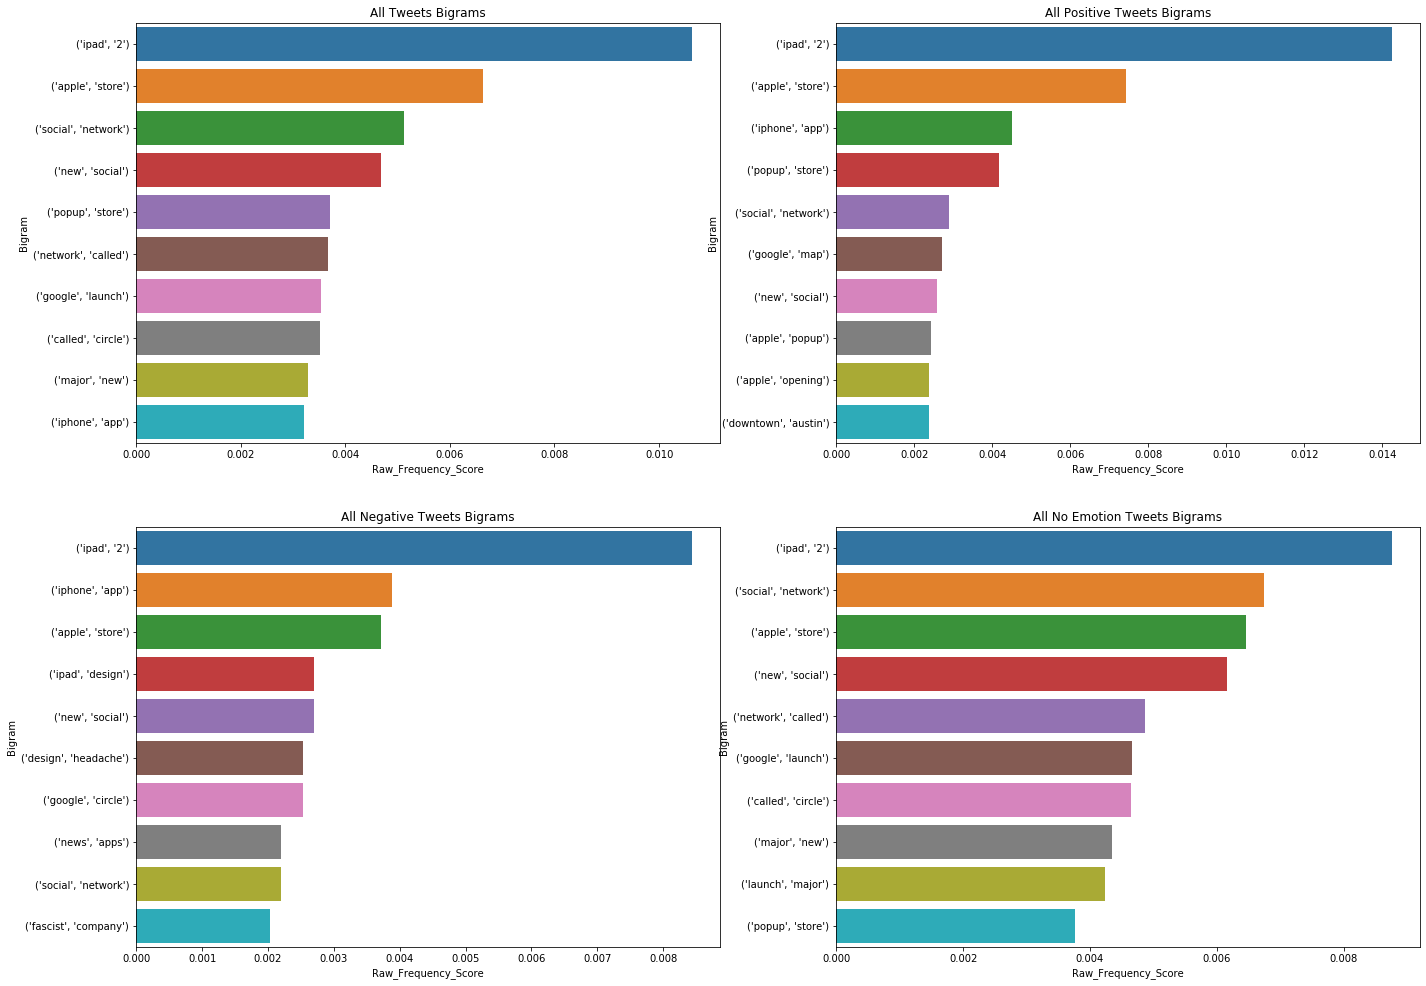

In [34]:
df_graph1 = pd.DataFrame(tweets_scored_list[0][:10], columns = ['Bigram','Raw_Frequency_Score'])
df_graph2 = pd.DataFrame(tweets_scored_list[1][:10], columns = ['Bigram','Raw_Frequency_Score'])
df_graph3 = pd.DataFrame(tweets_scored_list[2][:10], columns = ['Bigram','Raw_Frequency_Score'])
df_graph4 = pd.DataFrame(tweets_scored_list[3][:10], columns = ['Bigram','Raw_Frequency_Score'])
fig, axs = plt.subplots(2,2)
fig.set_figheight(17)
fig.set_figwidth(23)
axs[0,0].title.set_text('All Tweets Bigrams')
axs[0,1].title.set_text('All Positive Tweets Bigrams')
axs[1,0].title.set_text('All Negative Tweets Bigrams')
axs[1,1].title.set_text('All No Emotion Tweets Bigrams')
sns.barplot(data=df_graph1, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[0,0])
sns.barplot(data=df_graph2, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[0,1])
sns.barplot(data=df_graph3, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[1,0])
sns.barplot(data=df_graph4, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[1,1])
plt.show()

Plotted the Apple Tweets Bigrams

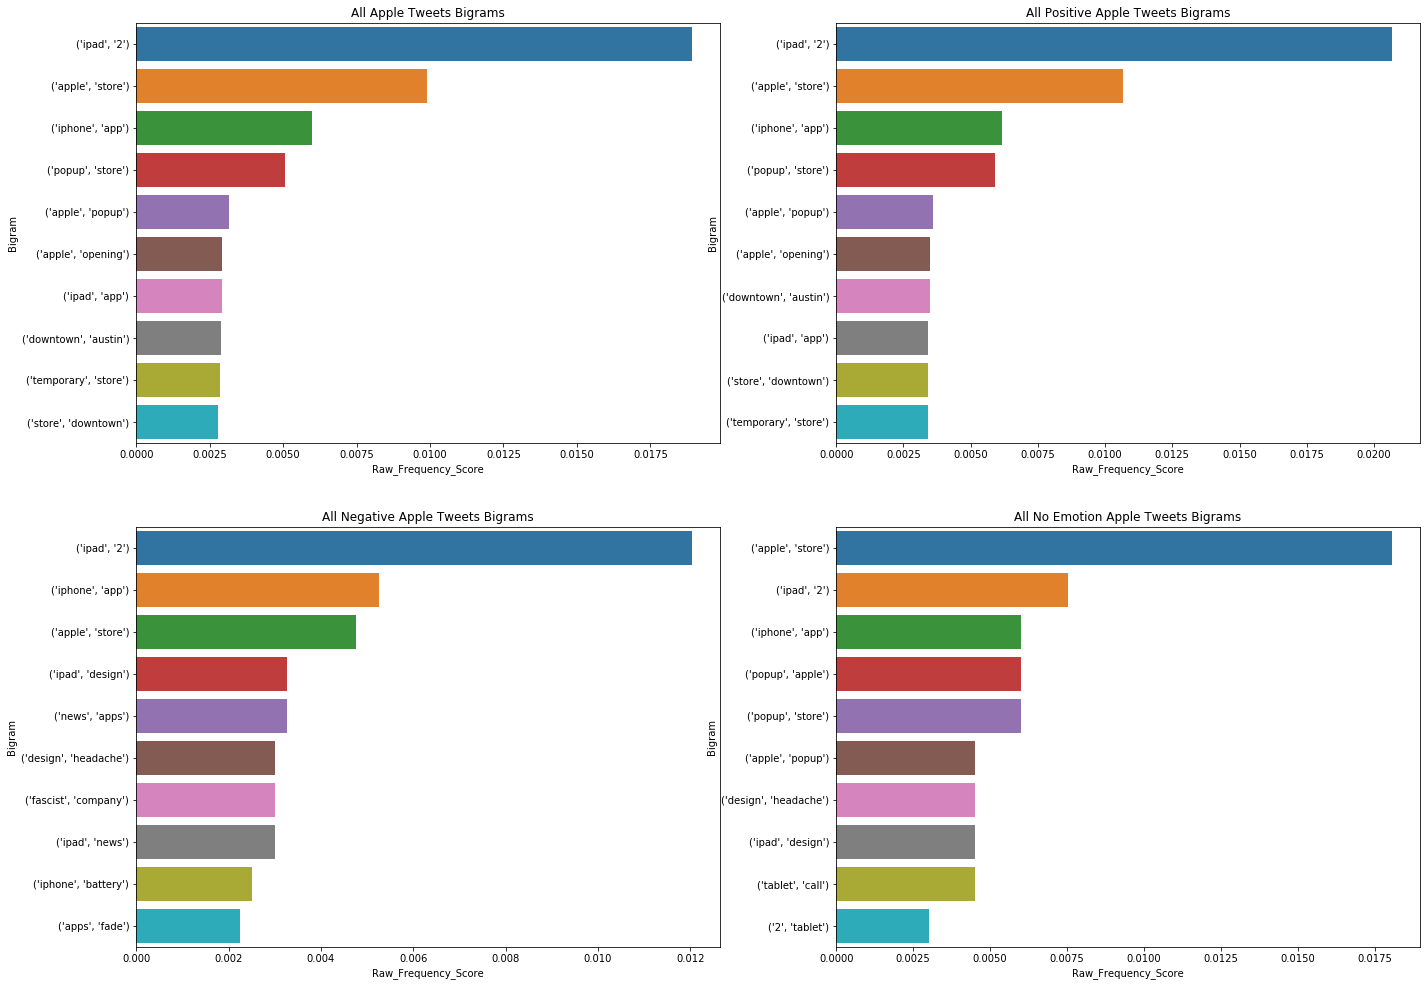

In [35]:
df_graph5 = pd.DataFrame(tweets_scored_list[4][:10], columns = ['Bigram','Raw_Frequency_Score'])
df_graph6 = pd.DataFrame(tweets_scored_list[5][:10], columns = ['Bigram','Raw_Frequency_Score'])
df_graph7 = pd.DataFrame(tweets_scored_list[6][:10], columns = ['Bigram','Raw_Frequency_Score'])
df_graph8 = pd.DataFrame(tweets_scored_list[7][:10], columns = ['Bigram','Raw_Frequency_Score'])
fig, axs = plt.subplots(2,2)
fig.set_figheight(17)
fig.set_figwidth(23)
axs[0,0].title.set_text('All Apple Tweets Bigrams')
axs[0,1].title.set_text('All Positive Apple Tweets Bigrams')
axs[1,0].title.set_text('All Negative Apple Tweets Bigrams')
axs[1,1].title.set_text('All No Emotion Apple Tweets Bigrams')
sns.barplot(data=df_graph5, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[0,0])
sns.barplot(data=df_graph6, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[0,1])
sns.barplot(data=df_graph7, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[1,0])
sns.barplot(data=df_graph8, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[1,1])
plt.show()

Plotted the Google Tweets Bigrams

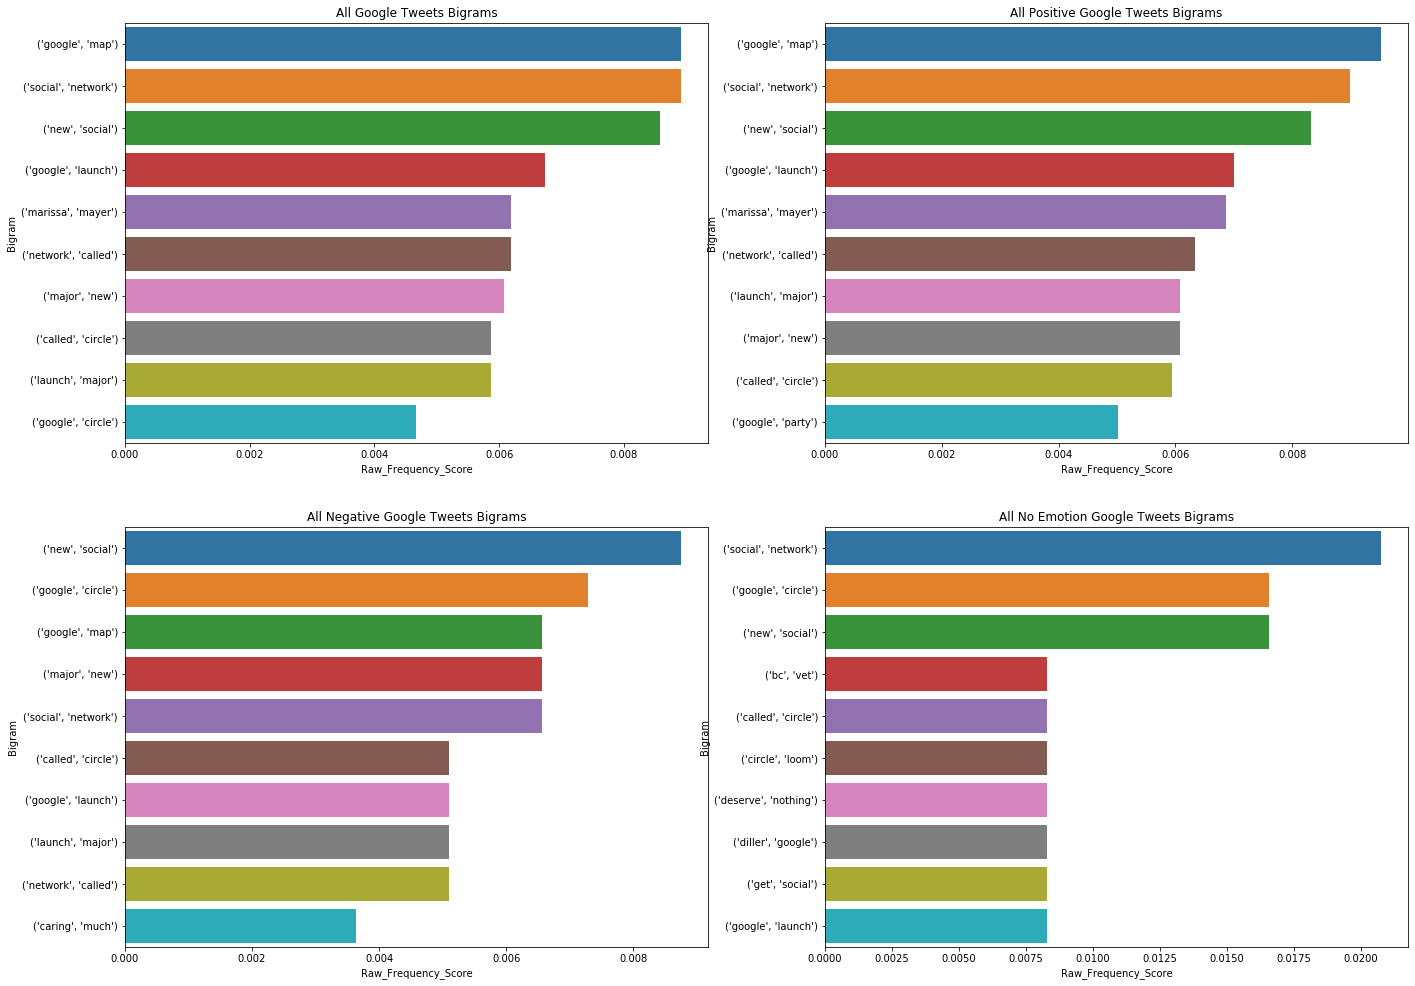

In [36]:
df_graph9 = pd.DataFrame(tweets_scored_list[8][:10], columns = ['Bigram','Raw_Frequency_Score'])
df_graph10 = pd.DataFrame(tweets_scored_list[9][:10], columns = ['Bigram','Raw_Frequency_Score'])
df_graph11 = pd.DataFrame(tweets_scored_list[10][:10], columns = ['Bigram','Raw_Frequency_Score'])
df_graph12 = pd.DataFrame(tweets_scored_list[11][:10], columns = ['Bigram','Raw_Frequency_Score'])
fig, axs = plt.subplots(2,2)
fig.set_figheight(17)
fig.set_figwidth(23)
axs[0,0].title.set_text('All Google Tweets Bigrams')
axs[0,1].title.set_text('All Positive Google Tweets Bigrams')
axs[1,0].title.set_text('All Negative Google Tweets Bigrams')
axs[1,1].title.set_text('All No Emotion Google Tweets Bigrams')
sns.barplot(data=df_graph9, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[0,0])
sns.barplot(data=df_graph10, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[0,1])
sns.barplot(data=df_graph11, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[1,0])
sns.barplot(data=df_graph12, y='Bigram',x='Raw_Frequency_Score', orient='h', ax = axs[1,1])
plt.show()

## Bigrams by Mutual Information Score

In [37]:
mobile_tweets_scored_list = []
for mobile_list in mobile_concat_list:
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    tweet_finder = BigramCollocationFinder.from_words(mobile_list)
    tweet_finder.apply_freq_filter(5)
    tweets_scored = tweet_finder.score_ngrams(bigram_measures.pmi)
    mobile_tweets_scored_list.append(tweets_scored)

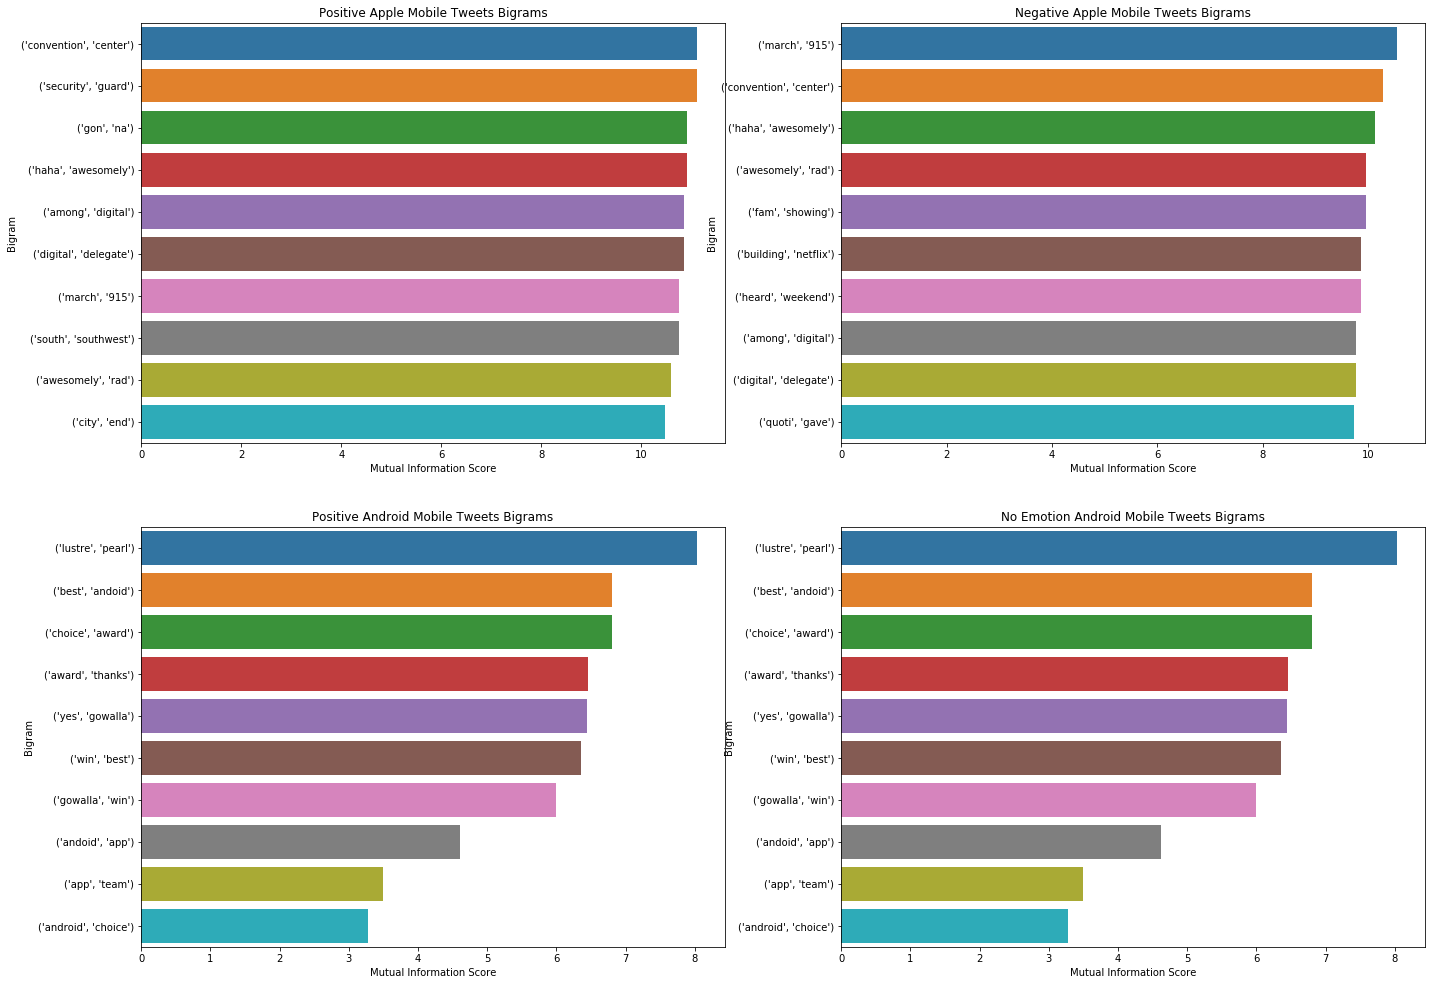

In [38]:
df_mobile_graph1 = pd.DataFrame(mobile_tweets_scored_list[0][:10], columns = ['Bigram','Mutual Information Score'])
df_mobile_graph2 = pd.DataFrame(mobile_tweets_scored_list[1][:10], columns = ['Bigram','Mutual Information Score'])
df_mobile_graph3 = pd.DataFrame(mobile_tweets_scored_list[2][:10], columns = ['Bigram','Mutual Information Score'])
df_mobile_graph4 = pd.DataFrame(mobile_tweets_scored_list[3][:10], columns = ['Bigram','Mutual Information Score'])
fig, axs = plt.subplots(2,2)
fig.set_figheight(17)
fig.set_figwidth(23)
axs[0,0].title.set_text('Positive Apple Mobile Tweets Bigrams')
axs[0,1].title.set_text('Negative Apple Mobile Tweets Bigrams')
axs[1,0].title.set_text('Positive Android Mobile Tweets Bigrams')
axs[1,1].title.set_text('No Emotion Android Mobile Tweets Bigrams')
sns.barplot(data=df_mobile_graph1, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[0,0])
sns.barplot(data=df_mobile_graph2, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[0,1])
sns.barplot(data=df_mobile_graph3, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[1,0])
sns.barplot(data=df_mobile_graph4, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[1,1])
plt.show()

Combined all Apple products and all Google products together

In [39]:
df_eda['brand_product']=df_eda['brand_product'].replace(to_replace = ['iPad','Apple',
                                                                                    'iPad or iPhone App','iPhone',
                                                                                    'Other Apple product or service'],value='apple_product')
df_eda['brand_product'] = df_eda['brand_product'].replace(['Google',
                                                                        'Other Google product or service',
                                                                        'Android App', 'Android'],'android_product')
df_eda['brand_product'].value_counts(
)

apple_product      2409
android_product     882
Name: brand_product, dtype: int64

Created new data frames based on different brands and sentiments to plot bigrams of most common word pairs

In [40]:
df_pos = df_eda.loc[df_eda['sentiment'] == 'Positive emotion']
df_neg = df_eda.loc[df_eda['sentiment'] == 'Negative emotion']
df_none = df_eda.loc[df_eda['sentiment'] == 'No emotion toward brand or product']
df_apple = df_eda.loc[df_eda['brand_product'] == 'apple_product']
df_google = df_eda.loc[df_eda['brand_product'] == 'android_product']
df_pos_apple = df_eda.loc[(df_eda['brand_product'] == 'apple_product') & (df_eda['sentiment'] == 'Positive emotion')]
df_neg_apple = df_eda.loc[(df_eda['brand_product'] == 'apple_product') & (df_eda['sentiment'] == 'Negative emotion')]
df_none_apple = df_eda.loc[(df_eda['brand_product'] == 'apple_product') & (df_eda['sentiment'] == 'No emotion toward brand or product')]
df_pos_google = df_eda.loc[(df_eda['brand_product'] == 'android_product') & (df_eda['sentiment'] == 'Positive emotion')]
df_neg_google = df_eda.loc[(df_eda['brand_product'] == 'android_product') & (df_eda['sentiment'] == 'Negative emotion')]
df_none_google = df_eda.loc[(df_eda['brand_product'] == 'android_product') & (df_eda['sentiment'] == 'No emotion toward brand or product')]

In [41]:
tweet_list = df_eda['tweet_text']
pos_tweet_list = df_pos['tweet_text']
neg_tweet_list = df_neg['tweet_text']
none_tweet_list = df_none['tweet_text']
apple_tweet_list = df_apple['tweet_text']
apple_pos_tweet_list = df_pos_apple['tweet_text']
apple_neg_tweet_list = df_neg_apple['tweet_text']
apple_none_tweet_list = df_none_apple['tweet_text']
google_tweet_list = df_google['tweet_text']
google_pos_tweet_list = df_pos_google['tweet_text']
google_neg_tweet_list = df_neg_google['tweet_text']
google_none_tweet_list = df_none_google['tweet_text']

In [42]:
tweet_concat = []
pos_tweet_concat = []
neg_tweet_concat = []
none_tweet_concat = []
apple_tweet_concat = []
apple_pos_tweet_concat = []
apple_neg_tweet_concat = []
apple_none_tweet_concat = []
google_tweet_concat = []
google_pos_tweet_concat = []
google_neg_tweet_concat = []
google_none_tweet_concat = []

for tweet in tweet_list:
    tweet_concat += tweet
for tweet in pos_tweet_list:
    pos_tweet_concat += tweet
for tweet in neg_tweet_list:
    neg_tweet_concat += tweet  
for tweet in none_tweet_list:
    none_tweet_concat += tweet

for tweet in apple_tweet_list:
    apple_tweet_concat += tweet
for tweet in apple_pos_tweet_list:
    apple_pos_tweet_concat += tweet
for tweet in apple_neg_tweet_list:
    apple_neg_tweet_concat += tweet  
for tweet in apple_none_tweet_list:
    apple_none_tweet_concat += tweet

for tweet in google_tweet_list:
    google_tweet_concat += tweet
for tweet in google_pos_tweet_list:
    google_pos_tweet_concat += tweet
for tweet in google_neg_tweet_list:
    google_neg_tweet_concat += tweet  
for tweet in google_none_tweet_list:
    google_none_tweet_concat += tweet

In [43]:
concat_list=[tweet_concat,
pos_tweet_concat,
neg_tweet_concat,
none_tweet_concat,
apple_tweet_concat,
apple_pos_tweet_concat,
apple_neg_tweet_concat,
apple_none_tweet_concat,
google_tweet_concat,
google_pos_tweet_concat,
google_neg_tweet_concat,
google_none_tweet_concat]

Used a for loop to collect Raw Frequency Scores for each subset of the data

In [44]:
tweets_scored_list = []
for list in concat_list:
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    tweet_finder = BigramCollocationFinder.from_words(list)
    tweets_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)
    tweets_scored_list.append(tweets_scored)

Plotted the All Tweets Bigrams

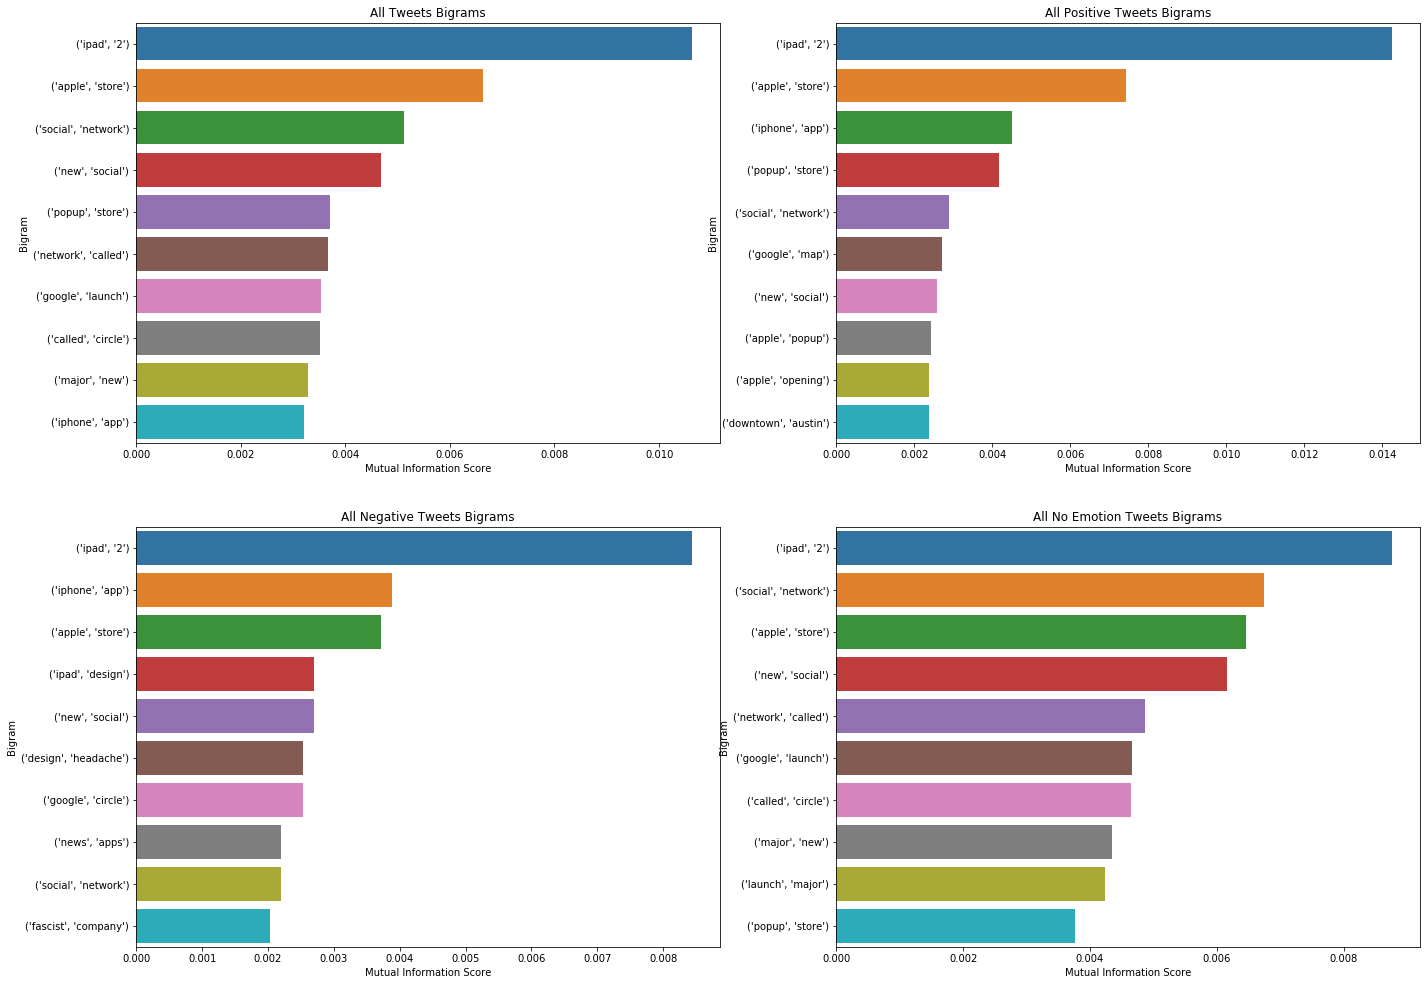

In [45]:
df_graph1 = pd.DataFrame(tweets_scored_list[0][:10], columns = ['Bigram','Mutual Information Score'])
df_graph2 = pd.DataFrame(tweets_scored_list[1][:10], columns = ['Bigram','Mutual Information Score'])
df_graph3 = pd.DataFrame(tweets_scored_list[2][:10], columns = ['Bigram','Mutual Information Score'])
df_graph4 = pd.DataFrame(tweets_scored_list[3][:10], columns = ['Bigram','Mutual Information Score'])
fig, axs = plt.subplots(2,2)
fig.set_figheight(17)
fig.set_figwidth(23)
axs[0,0].title.set_text('All Tweets Bigrams')
axs[0,1].title.set_text('All Positive Tweets Bigrams')
axs[1,0].title.set_text('All Negative Tweets Bigrams')
axs[1,1].title.set_text('All No Emotion Tweets Bigrams')
sns.barplot(data=df_graph1, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[0,0])
sns.barplot(data=df_graph2, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[0,1])
sns.barplot(data=df_graph3, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[1,0])
sns.barplot(data=df_graph4, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[1,1])
plt.show()

Plotted the Apple Tweets Bigrams

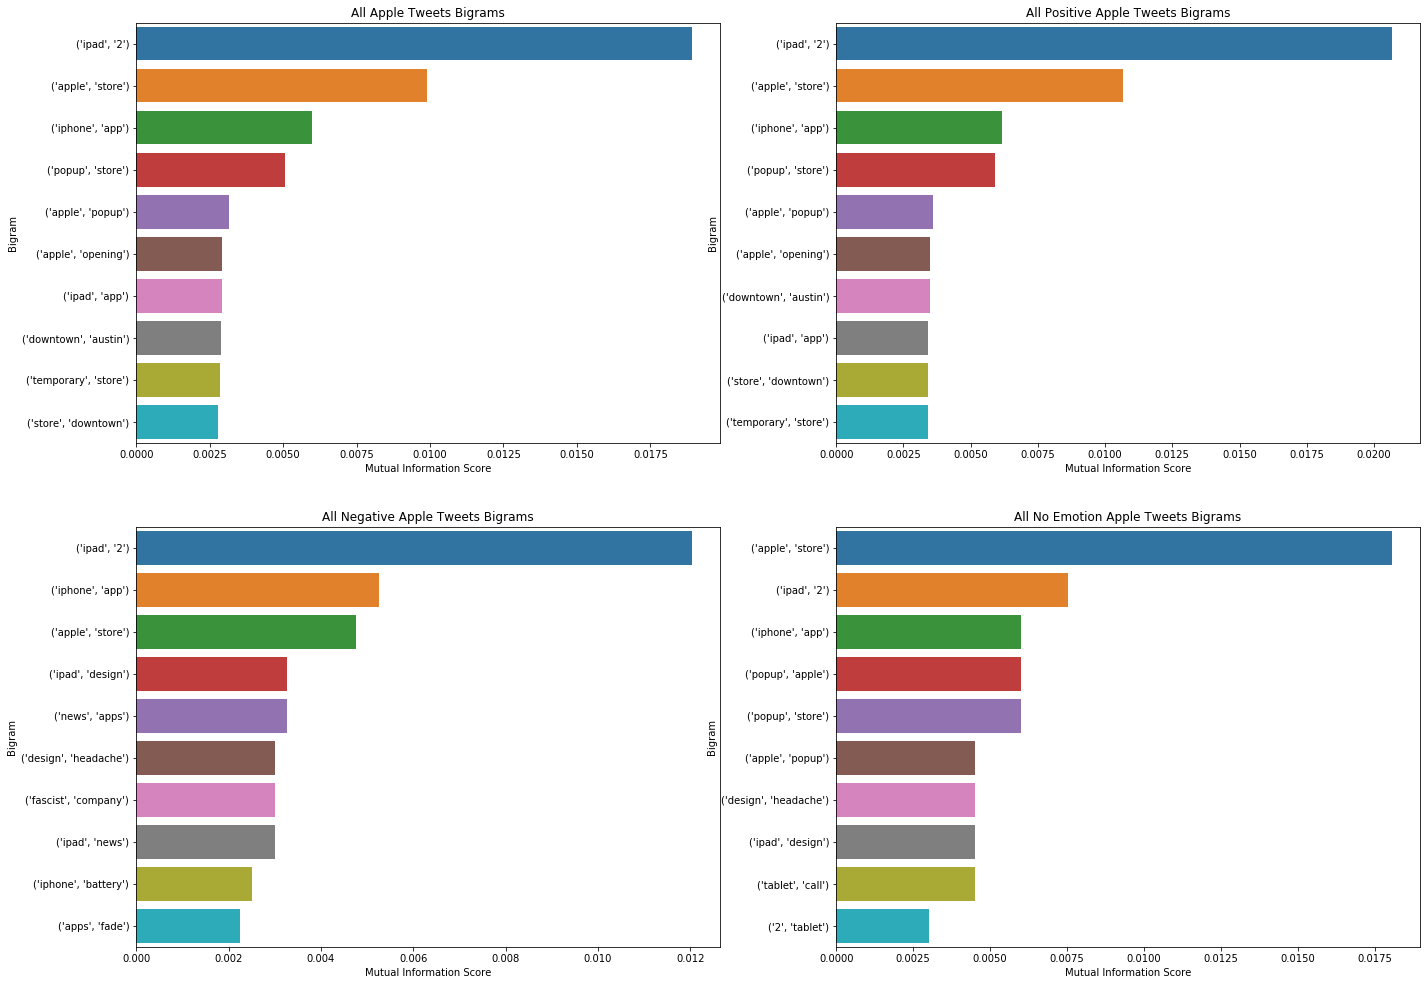

In [48]:
df_graph5 = pd.DataFrame(tweets_scored_list[4][:10], columns = ['Bigram','Mutual Information Score'])
df_graph6 = pd.DataFrame(tweets_scored_list[5][:10], columns = ['Bigram','Mutual Information Score'])
df_graph7 = pd.DataFrame(tweets_scored_list[6][:10], columns = ['Bigram','Mutual Information Score'])
df_graph8 = pd.DataFrame(tweets_scored_list[7][:10], columns = ['Bigram','Mutual Information Score'])
fig, axs = plt.subplots(2,2)
fig.set_figheight(17)
fig.set_figwidth(23)
axs[0,0].title.set_text('All Apple Tweets Bigrams')
axs[0,1].title.set_text('All Positive Apple Tweets Bigrams')
axs[1,0].title.set_text('All Negative Apple Tweets Bigrams')
axs[1,1].title.set_text('All No Emotion Apple Tweets Bigrams')
sns.barplot(data=df_graph5, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[0,0])
sns.barplot(data=df_graph6, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[0,1])
sns.barplot(data=df_graph7, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[1,0])
sns.barplot(data=df_graph8, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[1,1])
plt.savefig('figures/apple_bigrams_pmi.png')
plt.show()

Plotted the Google Tweets Bigrams

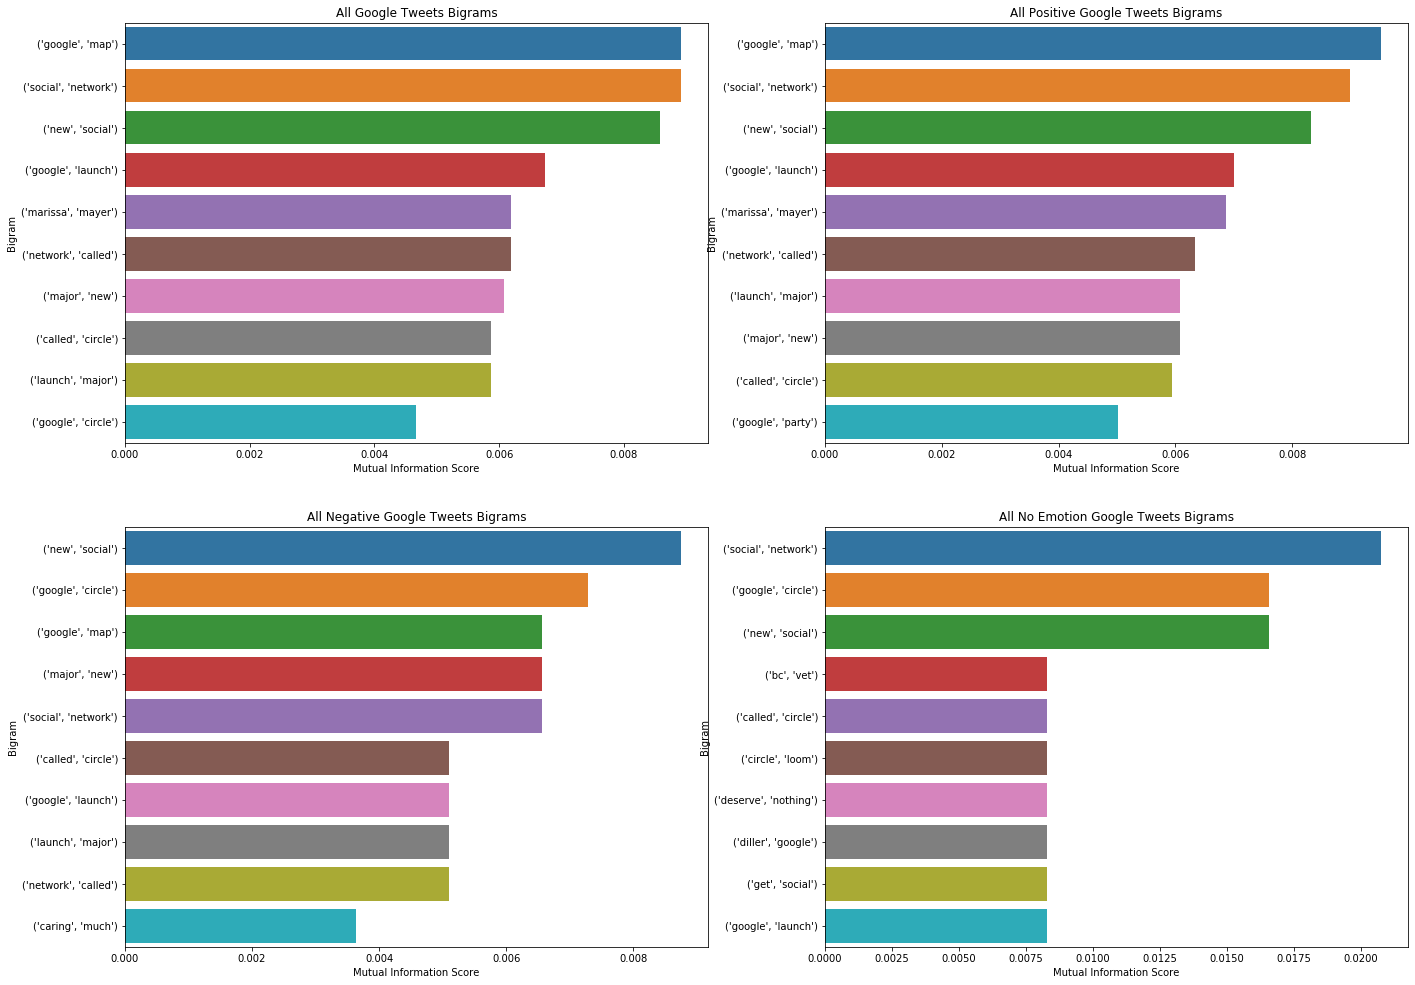

In [49]:
df_graph9 = pd.DataFrame(tweets_scored_list[8][:10], columns = ['Bigram','Mutual Information Score'])
df_graph10 = pd.DataFrame(tweets_scored_list[9][:10], columns = ['Bigram','Mutual Information Score'])
df_graph11 = pd.DataFrame(tweets_scored_list[10][:10], columns = ['Bigram','Mutual Information Score'])
df_graph12 = pd.DataFrame(tweets_scored_list[11][:10], columns = ['Bigram','Mutual Information Score'])
fig, axs = plt.subplots(2,2)
fig.set_figheight(17)
fig.set_figwidth(23)
axs[0,0].title.set_text('All Google Tweets Bigrams')
axs[0,1].title.set_text('All Positive Google Tweets Bigrams')
axs[1,0].title.set_text('All Negative Google Tweets Bigrams')
axs[1,1].title.set_text('All No Emotion Google Tweets Bigrams')
sns.barplot(data=df_graph9, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[0,0])
sns.barplot(data=df_graph10, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[0,1])
sns.barplot(data=df_graph11, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[1,0])
sns.barplot(data=df_graph12, y='Bigram',x='Mutual Information Score', orient='h', ax = axs[1,1])
plt.savefig('figures/google_bigrams_pmi.png')
plt.show()

### Preprocessing Tweets
Clean, lemmatize, and format data for vectorization and modeling

In [ ]:
df['tweet_text'] = df_eda['tweet_text'].map(lambda x: ' '.join(x))

### binary classification model
Split the DataFrame to take only binary options 

In [ ]:
binary = df[(df['sentiment'] == 'Negative emotion')|
            (df['sentiment'] == 'Positive emotion')]

vectorize the data

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(binary['tweet_text'])
Y = binary['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2)

Created empty DataFrame to track results of the model

In [ ]:
model_results = pd.DataFrame()
model_results.head()

### Logistic Regression

Ran vanilla Logistic Regression and Random Forest Classifier models with CountVectorizer and added results to DataFrame

In [ ]:
logreg = LogisticRegression(solver= 'lbfgs', 
                            multi_class = 'auto', 
                            max_iter = 400, 
                            class_weight = 'balanced')
report(logreg)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [1, 'Vanilla Logistic Regression', 0.0,0.0,0.0,50.0,92.0,53.0,91.0, 'Vanilla model very basic, needs tuning']
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results1)

In [ ]:
model_results

In [ ]:
rand_tree = RandomForestClassifier()
report(rand_tree)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [2, 'Vanilla Random Forest Classifier', 0.0,0.0,0.0,38.0,97.0,51.0,93.0, 'Vanilla model very basic, needs tuning']
results_dict = dict(zip(column_names,results))
model_results2=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results2)
model_results

# SMOTE

Created SMOTE train/test data split to explore answers to class imbalance

In [ ]:
smote = SMOTE()
X_res, y_res = smote.fit_resample(X,Y)

In [ ]:
X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE = train_test_split(X_res, y_res, test_size = 0.25, 
                                                                            random_state=42)

# Binary Support Vector Machine Modeling

Created binary modeling data set and assigned Sentiment Values either 0 (Negative) or 1 (Positive)

In [ ]:
df_modeling = df_eda.loc[(df_eda['sentiment'] == 'Positive emotion') | 
                         (df_eda['sentiment'] == 'Negative emotion')]
df_modeling['sentiment'] = df_modeling['sentiment'].replace({'Positive emotion':1,'Negative emotion':0})

In [ ]:
df_modeling['tweet_text'] = df_modeling['tweet_text']
df_modeling.head()

Vectorized tweet_text data and split data set into train and test sets

In [ ]:
tf_idfvectorizer = TfidfVectorizer(max_features = 400)

In [ ]:
X = df_modeling['tweet_text']
y = df_modeling['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=42)

In [ ]:
tf_idfvectorizer.fit(X)
X_train_tfidf = tf_idfvectorizer.transform(X_train)
X_test_tfidf = tf_idfvectorizer.transform(X_test)

Fit Vectorizer to tweet data and transformed using TfIDF Vectorizer. Ran first Support Vector Machine Model using Linear kernel and balanced data set

In [ ]:
svm_clf = SVC(kernel='linear', class_weight='balanced')
svm_clf.fit(X_train_tfidf,y_train)
y_test_preds = svm_clf.predict(X_test_tfidf)
y_train_preds = svm_clf.predict(X_train_tfidf)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Test SVM Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)
print("Training SVM Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [3, 'SVM: Balanced Class Weights, Linear Kernel', 81.3,76.4,4.9,67.0,78.0,47.0,85.0, 'Model overfits and class imbalance still causing issues with model']
results_dict = dict(zip(column_names,results))
model_results3=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results3)
model_results

Model overfit. Performed GridSearch to find optimal parameters for model

In [ ]:
params_svc = {'C': [0.1, 1, 10, 100], 'gamma':[1,0.1,0.01,0.001]}
estimator_svc = SVC(kernel='linear',
                    class_weight='balanced')
grid_search_svc = GridSearchCV(estimator=estimator_svc, 
                              param_grid=params_svc,
                              scoring = 'accuracy',
                              n_jobs = -1,
                              cv = 10,
                              verbose = True)

In [ ]:
grid_search_svc.fit(X_train_tfidf, y_train)

In [ ]:
grid_search_svc.best_params_

In [ ]:
svm_clf = SVC(kernel='linear', class_weight='balanced', C = 10, gamma= 1)
svm_clf.fit(X_train_tfidf,y_train)
y_test_preds = svm_clf.predict(X_test_tfidf)
y_train_preds = svm_clf.predict(X_train_tfidf)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Test SVM Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)
print("Training SVM Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [4, 'SVM: Balanced Class Weights, Linear Kernel, GridSearch Params', 
           84.5,75.6,8.9,64.0,78.0,45.0,84.0, 'Model still overfits and less predictive for both classes']
results_dict = dict(zip(column_names,results))
model_results4=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results4)
model_results

Tried best performing SVC model with the SMOTE data to see the effect

In [ ]:
svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train_SMOTE,y_train_SMOTE)
y_test_preds = svm_clf.predict(X_test_SMOTE)
y_train_preds = svm_clf.predict(X_train_SMOTE)
print(classification_report(y_test_SMOTE, y_test_preds))
print(confusion_matrix(y_test_SMOTE, y_test_preds))
print("Test SVM Accuracy Score -> ",accuracy_score(y_test_SMOTE, y_test_preds)*100)
print("Training SVM Accuracy Score -> ",accuracy_score(y_train_SMOTE, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [5, 'SVM: SMOTE', 99.2,88.9,10.3,93.0,85.0,89.0,89.0, 'Model overfits but SMOTE has solved class imbalance issues']
results_dict = dict(zip(column_names,results))
model_results5=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results5)
model_results

Model continues to overfit. Moving to XGBoosted Model to see if that works better

# Binary XGBoost Model

Fit vanilla XGBoosted RFC on TfIdf Vectorized Data

In [ ]:
xgbc_clf = XGBClassifier()
xgbc_clf.fit(X_train_tfidf, y_train)
y_test_preds = xgbc_clf.predict(X_test_tfidf)
y_train_preds = xgbc_clf.predict(X_train_tfidf)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Test XGBoosted Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)
print("Training XGBoosted Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)

Model performed much better than Support Vector Machine. Pos_scale_weight is a parameter that can weight the data set towards the minority class. Used a for loop to test 100 different models with a pos_scale_weight from 0.01 to 1.0 to see which combo has smallest difference in train/test accuracy scores and highest test accuracy score. 

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [6, 'XGBoost RFC Vanilla', 85.8,85.1,0.7,9.0,99.0,15.0,92.0, 'Model is basically guessing 1 every time']
results_dict = dict(zip(column_names,results))
model_results6=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results6)
model_results

In [ ]:
train_test_difference = []
train_score = []
test_score = []
for i in np.arange(0.01, 1.01, 0.01):
    xgbc_clf = XGBClassifier(scale_pos_weight=i)
    xgbc_clf.fit(X_train_tfidf, y_train)
    y_test_preds = xgbc_clf.predict(X_test_tfidf)
    y_train_preds = xgbc_clf.predict(X_train_tfidf)
    train_test_difference.append((accuracy_score(y_train, y_train_preds) * 100) - 
                                 (accuracy_score(y_test, y_test_preds)*100))
    train_score.append(accuracy_score(y_train, y_train_preds) * 100)
    test_score.append(accuracy_score(y_test, y_test_preds)*100)

In [ ]:
df_results=pd.DataFrame([np.arange(0.01, 1.01, 0.01), train_test_difference, train_score, test_score]).T
df_results=df_results.rename(columns = {0:'pos_scale_weight',1:'train_test_difference', 2:'train_score', 3:'test_score'})
df_results.sort_values(['train_test_difference','test_score'])

Re ran model with optimal pos_scale_weight value

In [ ]:
xgbc_clf = XGBClassifier(scale_pos_weight=.96)
xgbc_clf.fit(X_train_tfidf, y_train)
y_test_preds = xgbc_clf.predict(X_test_tfidf)
y_train_preds = xgbc_clf.predict(X_train_tfidf)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Test SVM Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)
print("Training SVM Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [7, 'XGBoost, pos_scale_weight', 86.1,85.4,0.7,11.0,99.0,47.0,92.0, 'Class imbalance still causing issues with model']
results_dict = dict(zip(column_names,results))
model_results7=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results7)
model_results

Slightly increased overfit. Running GridSearch to see if I can optimize model further

In [ ]:
params_xgboost = {'max_depth': range(2,10,1),
         'n_estimators': range(60,220,40),
         'learning_rate': [0.1, 0.01, 0.05]}
estimator_xgboost = XGBClassifier(
    objective= 'binary:logistic',
    n_jobs=-1,
    seed=42, 
    pos_scale_weight = .96
)
grid_search_xgboost = GridSearchCV(
    estimator=estimator_xgboost,
    param_grid=params_xgboost,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 10,
    verbose=True)

In [ ]:
grid_search_xgboost.fit(X_train_tfidf, y_train)

In [ ]:
grid_search_xgboost.best_params_

Ran new model with optimal parameters. Reduced max_depth manually to avoid overfitting

In [ ]:
xgbc_clf = XGBClassifier(scale_pos_weight=.96, learning_rate = 0.1, max_depth = 3, n_estimators = 180)
xgbc_clf.fit(X_train_tfidf, y_train)
y_test_preds = xgbc_clf.predict(X_test_tfidf)
y_train_preds = xgbc_clf.predict(X_train_tfidf)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Test SVM Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)
print("Training SVM Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [8, 'XGBoost GridSearch', 87.7,85.1,2.6,12.0,99.0,20.0,92.0, 'Class imbalance still causing issues with model']
results_dict = dict(zip(column_names,results))
model_results8=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results8)
model_results

Ran best fit model with SMOTE data to help with poor recall and precision scores for the 0 class

In [ ]:
xgbc_clf_final = XGBClassifier(scale_pos_weight=.96, learning_rate = 0.1, max_depth = 3, n_estimators = 180)
xgbc_clf_final.fit(X_train_SMOTE, y_train_SMOTE)
y_test_preds = xgbc_clf_final.predict(X_test_SMOTE)
y_train_preds = xgbc_clf_final.predict(X_train_SMOTE)
print(classification_report(y_test_SMOTE, y_test_preds))
print(confusion_matrix(y_test_SMOTE, y_test_preds))
print("Test XGBoosted Accuracy Score -> ",accuracy_score(y_test_SMOTE, y_test_preds)*100)
print("Training XGBoosted Accuracy Score -> ",accuracy_score(y_train_SMOTE, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'negative_f_1', 'positive_f-1', 'notes']
results = [9, 'XGBoost SMOTE', 89.8,89.2,0.6,80.0,98.0,88.0,90.0, 
           'SMOTE fixed class imbalance. Best performing binary model']
results_dict = dict(zip(column_names,results))
model_results9=pd.DataFrame(results_dict, index = range(1))
model_results=model_results.append(model_results9)
model_results

In [ ]:
feature_important = xgbc_clf.get_booster().get_score(importance_type='weight')
keys = feature_important.keys()
values = feature_important.values()
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data20=data.head(20)
data20.plot(kind='barh')
data20.head()

In [ ]:
def predict_sentiment(model):
    data = input(str('Enter a test tweet...'))
    cleaned_data = clean_lemmatize_token(data)
    next_step = [cleaned_data, '']
    vect_data = tf_idfvectorizer.transform(next_step)
    model = XGBClassifier(scale_pos_weight=.96, learning_rate = 0.1, 
                          max_depth = 3, n_estimators = 180)
    model.fit(X_train_SMOTE, y_train_SMOTE)
    pred = model.predict(vect_data)
    return pred

# Non-Binary Models

XGBoosted Random Forest Classifier showed that it was the best model for binary classification. So now we can move on to Non-Binary Classifications

In [ ]:
df_modeling3 = df_eda.loc[df_eda['sentiment'] != "I can't tell"]

In [ ]:
X = df_modeling3['tweet_text']
y = df_modeling3['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(X)
X_train_tfidf=tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Created empty data frame to track non-binary results

In [ ]:
model_results_nonbinary = pd.DataFrame()
model_results_nonbinary

Created SMOTE sample to test for class imbalance

In [ ]:
smote = SMOTE()
X_res, y_res = smote.fit_resample(X,y)
X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE = train_test_split(X_res, y_res, test_size=0.25,
                                                                           random_state=42)

# Support Vector Machines

Explored SVM with Linear kernel and balanced class weights first. Used params from best performing binary SVM model

In [ ]:
svm_clf = SVC(kernel='linear', class_weight='balanced', C = 10, gamma=1)
svm_clf.fit(X_train_tfidf, y_train)
y_test_preds = svm_clf.predict(X_test_tfidf)
y_train_preds = svm_clf.predict(X_train_tfidf)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Test SVM Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)
print("Training SVM Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'no_emotion_recall', 'negative_f_1', 'positive_f-1','no_emotion_f-1', 'notes']
results = [1, 'SVM: Vanilla Linear Kernel Class Weight Balanced', 93.0,66.6,26.4,34.0,58.0,75.0,38.0, 57.0, 75.0, 
           'Model overfits, and class imbalance is an issue']
results_dict = dict(zip(column_names,results))
model_results1=pd.DataFrame(results_dict, index = range(1))
model_results_nonbinary=model_results_nonbinary.append(model_results1)
model_results_nonbinary

Performed GridSearch on new non-binary model

In [ ]:
params_svc = {'C': [0.1, 1, 10, 100], 'gamma':[1,0.1,0.01,0.001]}
estimator_svc = SVC(kernel='linear',
                    class_weight='balanced')
grid_search_svc = GridSearchCV(estimator=estimator_svc, 
                              param_grid=params_svc,
                              scoring = 'accuracy',
                              n_jobs = -1,
                              cv = 10,
                              verbose = True)

In [ ]:
grid_search_svc.fit(X_train_tfidf, y_train)

In [ ]:
grid_search_svc.best_params_

Fit new model with ideal params. Still overfit so we manually adjusted params 

In [ ]:
svm_clf = SVC(kernel='linear', class_weight='balanced', C = 0.25, gamma='auto')
svm_clf.fit(X_train_tfidf, y_train)
y_test_preds = svm_clf.predict(X_test_tfidf)
y_train_preds = svm_clf.predict(X_train_tfidf)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Test SVM Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)
print("Training SVM Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'no_emotion_recall', 'negative_f_1', 'positive_f-1','no_emotion_f-1', 'notes']
results = [2, 'SVM: GridSearch Balanced Class Weights', 75.0,61.8,13.2,49.0,55.0,67.0,38.0, 53.0, 71.0, 
           'Model still overfits, and class imbalance is still an issue']
results_dict = dict(zip(column_names,results))
model_results2=pd.DataFrame(results_dict, index = range(1))
model_results_nonbinary=model_results_nonbinary.append(model_results2)
model_results_nonbinary

In [ ]:
svm_clf = SVC(kernel='linear', C = 5, gamma=1)
svm_clf.fit(X_train_SMOTE, y_train_SMOTE)
y_test_preds = svm_clf.predict(X_test_SMOTE)
y_train_preds = svm_clf.predict(X_train_SMOTE)
print(classification_report(y_test_SMOTE, y_test_preds))
print(confusion_matrix(y_test_SMOTE, y_test_preds))
print("Test SVM Accuracy Score -> ",accuracy_score(y_test_SMOTE, y_test_preds)*100)
print("Training SVM Accuracy Score -> ",accuracy_score(y_train_SMOTE, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'no_emotion_recall', 'negative_f_1', 'positive_f-1','no_emotion_f-1', 'notes']
results = [3, 'SVM: SMOTE', 94.7,83.6,11.1,100.0,82.0,70.0,96.0, 75.0, 79.0, 
           'Model still overfits, and class imbalance less an issue']
results_dict = dict(zip(column_names,results))
model_results3=pd.DataFrame(results_dict, index = range(1))
model_results_nonbinary=model_results_nonbinary.append(model_results3)
model_results_nonbinary

Running additional GridSearch fit on SMOTE Data

In [ ]:
params_svc = {'C': [0.1, 1, 10, 100], 'gamma':[1,0.1,0.01,0.001]}
estimator_svc = SVC(kernel='linear')
grid_search_svc = GridSearchCV(estimator=estimator_svc, 
                              param_grid=params_svc,
                              scoring = 'accuracy',
                              n_jobs = -1,
                              cv = 15,
                              verbose = True)

In [ ]:
grid_search_svc.fit(X_train_SMOTE, y_train_SMOTE)

In [ ]:
grid_search_svc.best_params_

# XGBoosted Model

Moving on to XGBoosted modeling. Change objective to multi:logistic to account for multi class target

In [ ]:
xgbc_clf = XGBClassifier(objective='multi:logistic')
xgbc_clf.fit(X_train_tfidf, y_train)
y_test_preds = xgbc_clf.predict(X_test_tfidf)
y_train_preds = xgbc_clf.predict(X_train_tfidf)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Test SVM Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)
print("Training SVM Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'no_emotion_recall', 'negative_f_1', 'positive_f-1','no_emotion_f-1', 'notes']
results = [4, 'XGBoost multi:logistic', 69.4,65.2,4.2,4.0,95.0,22.0,8.0, 77.0, 33.0, 
           'Model still overfits, and class imbalance less an issue']
results_dict = dict(zip(column_names,results))
model_results4=pd.DataFrame(results_dict, index = range(1))
model_results_nonbinary=model_results_nonbinary.append(model_results4)
model_results_nonbinary

Model slightly overfit and class imbalance is still an issue. Moving on to GridSearch

In [ ]:
params_xgboost = {'max_depth': range(2,10,1),
         'n_estimators': range(60,220,40),
         'learning_rate': [0.1, 0.01, 0.05]}

estimator_xgboost = XGBClassifier(
    objective= 'multi:logistic',
    n_jobs=-1,
    seed=42
)
grid_search_xgboost = GridSearchCV(
    estimator=estimator_xgboost,
    param_grid=params_xgboost,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10,
    verbose=True)

In [ ]:
grid_search_xgboost.fit(X_train_tfidf, y_train)

In [ ]:
grid_search_xgboost.best_params_

Fit model to best GridSearch params

In [ ]:
xgbc_clf = XGBClassifier(objective='multi:logistic',learning_rate=0.1, max_depth=1, n_estimators=750)
xgbc_clf.fit(X_train_tfidf, y_train)
y_test_preds = xgbc_clf.predict(X_test_tfidf)
y_train_preds = xgbc_clf.predict(X_train_tfidf)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Test SVM Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)
print("Training SVM Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'no_emotion_recall', 'negative_f_1', 'positive_f-1','no_emotion_f-1', 'notes']
results = [5, 'XGboost GridSearch', 71.1,65.9,5.2,8.0,29.0,92.0,14.0, 40.0, 77.0, 
           'Model still overfits, and class imbalance less an issue']
results_dict = dict(zip(column_names,results))
model_results5=pd.DataFrame(results_dict, index = range(1))
model_results_nonbinary=model_results_nonbinary.append(model_results5)
model_results_nonbinary

In [ ]:
xgbc_clf = XGBClassifier(objective='multi:logistic',learning_rate=0.1, max_depth=1, n_estimators=500)
xgbc_clf.fit(X_train_SMOTE, y_train_SMOTE)
y_test_preds = xgbc_clf.predict(X_test_SMOTE)
y_train_preds = xgbc_clf.predict(X_train_SMOTE)
print(classification_report(y_test_SMOTE, y_test_preds))
print(confusion_matrix(y_test_SMOTE, y_test_preds))
print("Test SVM Accuracy Score -> ",accuracy_score(y_test_SMOTE, y_test_preds)*100)
print("Training SVM Accuracy Score -> ",accuracy_score(y_train_SMOTE, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'no_emotion_recall', 'negative_f_1', 'positive_f-1','no_emotion_f-1', 'notes']
results = [6, 'XGboost SMOTE', 72.7,69.4,3.3,77.0,49.0,82.0,81.0, 57.0, 69.0, 
           'Model does not overfit and class imbalance no longer an issue']
results_dict = dict(zip(column_names,results))
model_results6=pd.DataFrame(results_dict, index = range(1))
model_results_nonbinary=model_results_nonbinary.append(model_results6)
model_results_nonbinary

# Naive Bayes Multiclass Model

After researching text classification methods I learned that Multinomial Naive Bayes models 

In [ ]:
model = make_pipeline(TfidfVectorizer(ngram_range=(1,2), max_features=400), MultinomialNB(alpha = 0.001))

In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
X = df_modeling3['tweet_text']
y = df_modeling3['sentiment']

In [ ]:
sentiment_encoded = le.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,sentiment_encoded, test_size=0.25, random_state=42)

In [ ]:
tf_idfvectorizer = TfidfVectorizer(ngram_range=(1,3),max_features=400)
tf_idfvectorizer.fit(X)
X_train_tfidf = tf_idfvectorizer.transform(X_train)
X_test_tfidf = tf_idfvectorizer.transform(X_test)

In [ ]:
model.fit(X_train, y_train)
y_test_preds = model.predict(X_test)
y_train_preds = model.predict(X_train)
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))
print("Test SVM Accuracy Score -> ",accuracy_score(y_test, y_test_preds)*100)
print("Training SVM Accuracy Score -> ",accuracy_score(y_train, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'no_emotion_recall', 'negative_f_1', 'positive_f-1','no_emotion_f-1', 'notes']
results = [7, 'Vanilla NB Model', 67.9,63.9,4.0,4.0,34.0,87.0,8.0, 42.0, 75.0, 
           'Naive Bayes has a lot of class imbalance issues']
results_dict = dict(zip(column_names,results))
model_results7=pd.DataFrame(results_dict, index = range(1))
model_results_nonbinary=model_results_nonbinary.append(model_results7)
model_results_nonbinary

In [ ]:
model = MultinomialNB(alpha = 1e-10, fit_prior=False)
model.fit(X_train_SMOTE, y_train_SMOTE)
y_test_preds = model.predict(X_test_SMOTE)
y_train_preds = model.predict(X_train_SMOTE)
print(classification_report(y_test_SMOTE, y_test_preds))
print(confusion_matrix(y_test_SMOTE, y_test_preds))
print("Test Accuracy Score -> ",accuracy_score(y_test_SMOTE, y_test_preds)*100)
print("Training Accuracy Score -> ",accuracy_score(y_train_SMOTE, y_train_preds)*100)

In [ ]:
column_names = ['model_#', 'model_type', 'train_accuracy', 'test_accuracy', 'train_test_diff' ,'negative_recall', 
                'positive_recall', 'no_emotion_recall', 'negative_f_1', 'positive_f-1','no_emotion_f-1', 'notes']
results = [8, 'SMOTE NB Model', 91.1,81.3,9.8,99.0,82.0,82.0,95.0, 70.0, 77.0, 
           'Naive Bayes has a lot of class imbalance issues']
results_dict = dict(zip(column_names,results))
model_results8=pd.DataFrame(results_dict, index = range(1))
model_results_nonbinary=model_results_nonbinary.append(model_results8)
model_results_nonbinary

In [ ]:
model_results

In [ ]:
model_results_fit=model_results.loc[model_results['train_test_diff'] < 3.0]
model_results_fit=model_results_fit.drop(columns = 'train_test_diff')
model_results_fit

In [ ]:
cols_to_plot=model_results_fit.columns[2:8]
plt.figure(figsize=(18,5))
for col in cols_to_plot:
    #used a for loop to plot evaluation metrics data from model_results data frame
    sns.scatterplot(data=model_results_fit, y=col, x='model_type', label = col,s=200)
plt.title('Evaluation Metrics by Binary Model Type',size=20)
plt.xlabel('Model Type',size=15)
plt.ylabel('Score',size = 15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.legend(loc = 'lower left', fontsize='x-large')
plt.show()

In [ ]:
model_results_nonbinary_fit = model_results_nonbinary.loc[model_results_nonbinary['train_test_diff']
                                                         <= 10.0]
model_results_nonbinary_fit=model_results_nonbinary_fit.drop(columns = 'train_test_diff')
model_results_nonbinary_fit

NameError: name 'model_results_nonbinary' is not defined

In [ ]:
cols_to_plot=model_results_nonbinary_fit.columns[2:10]
plt.figure(figsize=(12,5))
for col in cols_to_plot:
    #used a for loop to plot evaluation metrics data from model_results data frame
    sns.scatterplot(data=model_results_nonbinary_fit, y=col, x='model_type', label = col,s=200)
plt.title('Evaluation Metrics by Multi-Class Model Type',size=20)
plt.xlabel('Model Type',size=15)
plt.ylabel('Score',size = 15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.legend(loc = 'lower right', fontsize='small')
plt.show()

# Conclusion

After running our Twitter data through our binary and multiclass models, by far the most predictive models were identified. 

For the binary model, the tuned XGBoosted Random Forest Classifier trained on the SMOTE data was the most predictive with an F-1 Score for the Positive and Negative classes of around 90%. The SMOTE data was instrumental in achieving a predictive model for both classes, something that was impossible for passing a balanced class weight.

For the multi-class model, the XGBoost Model performed very well, but not as well as it did in the case of the Binary model. A Naive Bayes model trained on the SMOTE data was able to more accurately predict the 3 classes in this instance, however the model overfit to the training data so much that we would not recommend it for deployment. In this instance, I would also recommmend the XGBoost Model for the multiclass problem as it was able to accurately predict the negative and no emotion classes around 80% of the time, while only predicting the positive class around 50% of the time. 
